# DES431 Project: Recommendation System

# Background

**MovieLens** is a movie recommendation system operated by GroupLens, a research group at the University of Minnesota. MovieLens has been developed to provide personalized movie recommendations to its users based on their viewing history and preferences.

# Tasks

1. This project is to be completed by a group of up to three students.
2. Propose and implement your own recommendation system based on the MovieLens dataset.
   - Use `ratings_train.csv` as the training set and `ratings_valid.csv` as the validation set.
   - Your recommendation system may utilize information from `movies.csv` for making recommendations.
   - The structure of the data files is detailed at `https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html`.
   - The goal of the recommendation system is to minimize the root-mean-square error (RMSE), i.e., to minimize the difference between the predicted and actual ratings.
   - You are required to modify the provided program to enhance recommendation quality. Submitting the original, unaltered program will be considered plagiarism.
3. Prepare slides for a 7-minute presentation that explains your proposed technique and algorithm for making recommendations, and demonstrates your RMSE results on the validation set. The slides must include
   - A diagram and detailed explanation of your model
   - Results on the validation set
   - A discussion of the pros and cons of your model
4. Submit your Python notebook and the presentation slides in PDF format via Google Classroom by May 5, 2025, at 23:59. 
   - All members of the group must individually submit their work to Google Classroom. 
   - Late submissions will not be accepted and will incur a 10% deduction. 
   - Do not procrastinate. Plagiarism and code duplication will be rigorously checked.
5. Present your work on either May 7 or May 14, within a 7-minute timeframe. Presentations exceeding 7 minutes will result in point deductions. The presentation schedule will be announced later.
6. Attend the presentation physically on-site in the classroom on both days. Late penalty will be applied.
7. Evaluate the presenations of all groups including your group. 

You need to complete all tasks (1--7). Failure to complete any task will result in a score deduction.


In [60]:
# Edit this cell for the group name and members
# Group name: Group
# Group member1: Sirinya Jirasit 6522781069
# Group member2: Pitchaya Worapaluk 6522781002
# Group member3: Krittinat Kongchong 6522790268

In [61]:
import numpy as np
import pandas as pd

# Loading data

In [62]:
ratings_train = pd.read_csv('ratings_train.csv')
ratings_valid = pd.read_csv('ratings_valid.csv')
movies = pd.read_csv('movies.csv')

In [63]:
ratings_train.describe()

,userId,movieId,rating,timestamp
count,96464.00000,96464.000000,96464.000000,9.646400e+04
mean,327.86935,19105.768059,3.509325,1.204483e+09
std,183.95296,35243.409786,1.041385,2.165283e+08
min,1.00000,1.000000,0.500000,8.281246e+08
25%,177.00000,1196.000000,3.000000,1.013395e+09
50%,330.00000,2959.000000,3.500000,1.182909e+09
75%,479.00000,7486.000000,4.000000,1.435993e+09
max,610.00000,193609.000000,5.000000,1.537799e+09


In [64]:
ratings_train.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [65]:
ratings_valid.head(10)

,userId,movieId,rating,timestamp
0,4,45,3.0,986935047
1,4,52,3.0,964622786
2,4,58,3.0,964538444
3,4,222,1.0,945629040
4,4,247,3.0,986848894
5,4,265,5.0,964538468
6,4,319,5.0,945079182
7,4,345,4.0,945629063
8,4,417,2.0,945078467
9,4,441,1.0,986934915


In [66]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


# Constructing model and predicting ratings

## Example 1

Predict ratings using the average rating

In [67]:
# Model construction: calculate the average rating for each movie from the training set
avg_rating = ratings_train[['movieId', 'rating']].groupby(by='movieId').mean()
	    
# Merge the average rating with the validation set to get the predicted ratings
ratings_pred = ratings_valid[['userId', 'movieId']].copy()
ratings_pred = ratings_pred.merge(avg_rating, on='movieId', how='left')

In [68]:
# Display the predicted ratings
ratings_pred.head(10)

,userId,movieId,rating
0,4,45,3.366667
1,4,52,3.520000
2,4,58,4.062500
3,4,222,3.928571
4,4,247,3.975000
5,4,265,3.913793
6,4,319,3.526316
7,4,345,3.573529
8,4,417,4.000000
9,4,441,3.986486


In [69]:
# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

r_true = ratings_valid['rating'].to_numpy()
r_pred = ratings_pred['rating'].to_numpy()

rmse = sqrt(mean_squared_error(r_true, r_pred))
print(f"RMSE = {rmse:.4f}")

RMSE = 0.9171


## Example 2

Use `Surprise`, a Python library for recommender systems (https://surpriselib.com/), to construct an SVD model and perform predictions

In [70]:
from surprise import Dataset, Reader, SVD

data_train = Dataset.load_from_df(ratings_train[['userId', 'movieId', 'rating']], reader=Reader(rating_scale=(1, 5)))
data_valid = Dataset.load_from_df(ratings_valid[['userId', 'movieId', 'rating']], reader=Reader(rating_scale=(1, 5)))

In [71]:
from surprise import accuracy
from surprise.model_selection import train_test_split
trainset = data_train.build_full_trainset()
model2 = SVD(n_factors=200, n_epochs=1000, lr_all=0.005, reg_all=0.02)
model2.fit(trainset)

In [72]:
validset = data_valid.build_full_trainset().build_testset()
predictions = model2.test(validset)
predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'true_r', 'est', 'details'])
accuracy.rmse(predictions, verbose=True)

RMSE: 0.8253


0.8252837702459027

In [73]:
predictions_df.head(10)

,uid,iid,true_r,est,details
0,4,45,3.0,3.894949,{'was_impossible': False}
1,4,52,3.0,3.073750,{'was_impossible': False}
2,4,58,3.0,4.125473,{'was_impossible': False}
3,4,222,1.0,3.441831,{'was_impossible': False}
4,4,247,3.0,3.716306,{'was_impossible': False}
5,4,265,5.0,2.993268,{'was_impossible': False}
6,4,319,5.0,3.249767,{'was_impossible': False}
7,4,345,4.0,2.662647,{'was_impossible': False}
8,4,417,2.0,3.176377,{'was_impossible': False}
9,4,441,1.0,3.777366,{'was_impossible': False}


## Example 3

Use `Surprise` to construct a user-based collaborative filtering model

In [74]:
from surprise import KNNWithMeans

model3 = KNNWithMeans(k=10, sim_options={'name': 'cosine', 'user_based': True})
model3.fit(trainset)
predictions = model3.test(validset)
predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'true_r', 'est', 'details'])
accuracy.rmse(predictions, verbose=True)
predictions_df.head(10)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8701


,uid,iid,true_r,est,details
0,4,45,3.0,3.861059,"{'actual_k': 10, 'was_impossible': False}"
1,4,52,3.0,3.814467,"{'actual_k': 10, 'was_impossible': False}"
2,4,58,3.0,4.004362,"{'actual_k': 10, 'was_impossible': False}"
3,4,222,1.0,4.081305,"{'actual_k': 10, 'was_impossible': False}"
4,4,247,3.0,4.139495,"{'actual_k': 10, 'was_impossible': False}"
5,4,265,5.0,3.480554,"{'actual_k': 10, 'was_impossible': False}"
6,4,319,5.0,3.925908,"{'actual_k': 10, 'was_impossible': False}"
7,4,345,4.0,3.766812,"{'actual_k': 10, 'was_impossible': False}"
8,4,417,2.0,4.140247,"{'actual_k': 10, 'was_impossible': False}"
9,4,441,1.0,4.074553,"{'actual_k': 10, 'was_impossible': False}"


## Our Project

## User-Based Collaborative Filtering (Model1)

In [75]:
from surprise import Dataset, Reader, KNNBasic, KNNBaseline
from surprise import accuracy

# Step 1: Load data using Reader
reader = Reader(rating_scale=(0.5, 5.0))
data_train = Dataset.load_from_df(ratings_train[['userId', 'movieId', 'rating']], reader)
trainset = data_train.build_full_trainset()

# Step 2: Define user-based CF with cosine similarity
sim_options = {'name': 'pearson_baseline', 'user_based': True}
user_cf_model = KNNBaseline(k=40, sim_options=sim_options)
user_cf_model.fit(trainset)

# Step 3: Predict ratings for validation set
validset = [(row[0], row[1], row[2]) for row in ratings_valid.itertuples(index=False)]
predictions_user = [user_cf_model.predict(uid, iid, r_ui) for uid, iid, r_ui in validset]

# Step 4: Evaluate model using RMSE
rmse_user = accuracy.rmse(predictions_user)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8680


## Item - Based Collaborative Filtering (Model2)
#This is model 2

In [76]:
from surprise import Dataset, Reader, KNNBasic #Reader?
from surprise import accuracy
# Load data using Reader
reader = Reader(rating_scale=(0.5, 5.0))
data_train = Dataset.load_from_df(ratings_train[['userId', 'movieId', 'rating']], reader) #convert pandas dataframe into surprise format
trainset = data_train.build_full_trainset() #prepare data for training

# Defin Item based
sim_options = {'name': 'cosine', 'user_based': False}
item_model = KNNBaseline(k=40, sim_options=sim_options)
item_model.fit(trainset) #create collab filtering model training data

#Prepare validation setตรวจสอบความถูกต้อง
validset = [(row[0],row[1],row[2]) for row in ratings_valid.itertuples(index=False)]
predictions_user = [item_model.predict(uid, iid, r_ui) for uid, iid, r_ui in validset]

#calculate RMSE
rmse_item = accuracy.rmse(predictions_user)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8809


## Item - Latent Factor Model (SVD) (Model3)
#This is model 3

In [77]:
from surprise import SVD
from surprise import accuracy

#bulid the model
svd_model = SVD(n_factors=150, n_epochs=50, lr_all=0.004, reg_all=0.02)
svd_model.fit(trainset)

#prepare validation similar model2
validset = [(row[0],row[1],row[2]) for row in ratings_valid.itertuples(index=False)]
predictions_svd = [svd_model.predict(uid, iid, r_ui) for uid, iid, r_ui in validset]

#calculate RMSE
rmse_svd = accuracy.rmse(predictions_svd)

RMSE: 0.8692


In [78]:
from surprise import SVDpp
from surprise import accuracy

#bulid the model
svd_model = SVDpp(n_factors=100, n_epochs=50, lr_all=0.004, reg_all=0.02)
svd_model.fit(trainset)

#prepare validation similar model2
validset = [(row[0],row[1],row[2]) for row in ratings_valid.itertuples(index=False)]
predictions_svd = [svd_model.predict(uid, iid, r_ui) for uid, iid, r_ui in validset]

#calculate RMSE
rmse_svd = accuracy.rmse(predictions_svd)

RMSE: 0.8549


# Model 4 (Ensemble)

In [79]:
ensemble_predictions = []

for u, i, r in validset:
    pred_user = user_cf_model.predict(u, i).est
    pred_item = item_model.predict(u, i).est
    pred_svd = svd_model.predict(u, i).est

    # Weighted average
    avg_pred = (0.2 * pred_user + 0.2 * pred_item + 0.6 * pred_svd)
    ensemble_predictions.append((r, avg_pred))

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

r_true = [real for real, pred in ensemble_predictions]
r_pred = [pred for real, pred in ensemble_predictions]

rmse_ensemble = sqrt(mean_squared_error(r_true, r_pred))
print(f"Final Ensemble RMSE: {rmse_ensemble:.4f}")

Final Ensemble RMSE: 0.8323


## Model 5 The finalist that we use


In [81]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import DataLoader, Dataset

# Check if AMD GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
ratings_train = pd.read_csv("ratings_train.csv", names=["userId", "movieId", "rating", "timestamp"], skiprows=1)
ratings_valid = pd.read_csv("ratings_valid.csv", names=["userId", "movieId", "rating", "timestamp"], skiprows=1)
movies = pd.read_csv("movies.csv", names=["movieId", "title", "genres"], skiprows=1)

# Preprocessing
user_ids = ratings_train["userId"].unique()
movie_ids = ratings_train["movieId"].unique()

# Create mappings for user and movie IDs
user_id_map = {uid: idx for idx, uid in enumerate(user_ids)}
movie_id_map = {mid: idx for idx, mid in enumerate(movie_ids)}

# Apply mappings to training and validation datasets
ratings_train["userId"] = ratings_train["userId"].map(user_id_map)
ratings_train["movieId"] = ratings_train["movieId"].map(movie_id_map)
ratings_valid["userId"] = ratings_valid["userId"].map(user_id_map)
ratings_valid["movieId"] = ratings_valid["movieId"].map(movie_id_map)

# Filter movies to include only those present in the training set
movies = movies[movies["movieId"].isin(movie_ids)]

# Process genres
movies["genres"] = movies["genres"].apply(lambda x: x.split("|"))
mlb = MultiLabelBinarizer()
genre_features = mlb.fit_transform(movies["genres"])
num_genres = genre_features.shape[1]

# Map movie IDs to genre features
movie_genre_map = {movie_id_map[mid]: genre_features[idx] for idx, mid in enumerate(movies["movieId"])}

# Dataset class
class RatingDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df["userId"].values, dtype=torch.long).to(device)
        self.movies = torch.tensor(df["movieId"].values, dtype=torch.long).to(device)
        self.ratings = torch.tensor(df["rating"].values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

train_dataset = RatingDataset(ratings_train)
valid_dataset = RatingDataset(ratings_valid)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Reduced batch size
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

# Model definition
class EnhancedMatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, num_genres, latent_dim):
        super(EnhancedMatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, latent_dim).to(device)
        self.movie_embedding = nn.Embedding(num_movies, latent_dim).to(device)
        self.genre_embedding = nn.Linear(num_genres, latent_dim).to(device)  # Genre encoding
        self.user_bias = nn.Embedding(num_users, 1).to(device)
        self.movie_bias = nn.Embedding(num_movies, 1).to(device)
        self.global_bias = nn.Parameter(torch.tensor(3.5)).to(device)  # Initialize with global mean
        self.dropout = nn.Dropout(0.2).to(device)  # Increased dropout

    def forward(self, user_idx, movie_idx, genre_features):
        user_latent = self.user_embedding(user_idx)
        movie_latent = self.movie_embedding(movie_idx)
        genre_latent = self.genre_embedding(genre_features)
        dot_product = (user_latent + genre_latent) * movie_latent  # Combine user, movie, and genre embeddings
        dot_product = self.dropout(dot_product).sum(dim=1)
        user_bias = self.user_bias(user_idx).squeeze()
        movie_bias = self.movie_bias(movie_idx).squeeze()
        prediction = self.global_bias + user_bias + movie_bias + dot_product
        return prediction

# Hyperparameters
latent_dim = 128  # Increased latent dimension
learning_rate = 0.0025  # Smaller learning rate
num_epochs = 200  # Increased number of epochs

# Initialize model
num_users = len(user_ids)
num_movies = len(movie_ids)
model = EnhancedMatrixFactorization(num_users, num_movies, num_genres, latent_dim).to(device)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Added stronger weight decay

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop with early stopping
best_rmse = float("inf")
patience = 10  # Increased patience
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for users, movies, ratings in train_loader:
        # Get genre features for the batch of movies
        movie_genres = torch.tensor([movie_genre_map[movie.item()] for movie in movies], dtype=torch.float32).to(device)
        optimizer.zero_grad()
        predictions = model(users, movies, movie_genres)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

    # Validation
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for users, movies, ratings in valid_loader:
            # Get genre features for the batch of movies
            movie_genres = torch.tensor([movie_genre_map[movie.item()] for movie in movies], dtype=torch.float32).to(device)
            preds = model(users, movies, movie_genres)
            predictions.extend(preds.cpu().numpy())
            targets.extend(ratings.cpu().numpy())

    rmse = np.sqrt(np.mean((np.array(predictions) - np.array(targets)) ** 2))
    print(f"Validation RMSE: {rmse}")

    # Early stopping and learning rate scheduling
    scheduler.step(rmse)  # Adjust learning rate based on validation RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break

print(f"Best Validation RMSE: {best_rmse}")

Using device: cpu
Epoch 1/200, Loss: 118.07880177485215
Validation RMSE: 8.534488677978516
Epoch 2/200, Loss: 70.65068073424483
Validation RMSE: 7.398396968841553
Epoch 3/200, Loss: 45.17217636867291
Validation RMSE: 6.536068439483643
Epoch 4/200, Loss: 30.141378197809114
Validation RMSE: 5.811162948608398
Epoch 5/200, Loss: 20.67369663430778
Validation RMSE: 5.165140628814697
Epoch 6/200, Loss: 15.002663329046031
Validation RMSE: 4.596747875213623
Epoch 7/200, Loss: 10.90179834947662
Validation RMSE: 4.0825724601745605
Epoch 8/200, Loss: 8.293206797354417
Validation RMSE: 3.626129627227783
Epoch 9/200, Loss: 6.441158730408241
Validation RMSE: 3.212604522705078
Epoch 10/200, Loss: 4.997562422676491
Validation RMSE: 2.8537182807922363
Epoch 11/200, Loss: 3.970655935038306
Validation RMSE: 2.5208585262298584
Epoch 12/200, Loss: 3.1776702759752857
Validation RMSE: 2.2567107677459717
Epoch 13/200, Loss: 2.505200098933212
Validation RMSE: 1.9849374294281006
Epoch 14/200, Loss: 2.02812722017

# compare 3 model

In [82]:
import pandas as pd

results = pd.DataFrame({
    'Model': ['User-Based CF', 'Item-Based CF', 'SVD (Latent Factor)'],
    'Similarity / Method': ['Cosine', 'Pearson', 'Latent Matrix'],
    'RMSE': [rmse_user, rmse_item, rmse_svd]
})

results

,Model,Similarity / Method,RMSE
0,User-Based CF,Cosine,0.867957
1,Item-Based CF,Pearson,0.880894
2,SVD (Latent Factor),Latent Matrix,0.854901


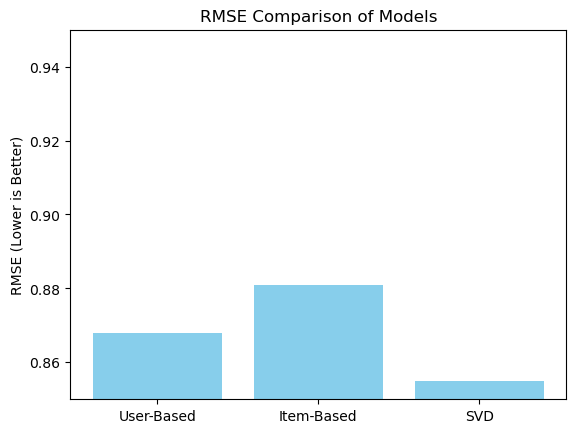

In [83]:
import matplotlib.pyplot as plt

plt.bar(['User-Based', 'Item-Based', 'SVD'], [rmse_user, rmse_item, rmse_svd], color='skyblue')
plt.title("RMSE Comparison of Models")
plt.ylabel("RMSE (Lower is Better)")
plt.ylim(0.85, 0.95)
plt.show()